# Local Sensitivity Analysis

This section demonstrates a post-optimality analysis using local sensitivity analysis based on finite difference gradients calculated using the surrogate of the objective and constraint function. It also demonstrates the effects of changing the limiting value of the constraint on the optimal solution of the problem, another important part of post-optimality analysis. The optimization problem used in this section is the constrained version of the modified Branin function problem also used in the Constrained Sequential Sampling section. The constrained minimum of the original problem is $f(x^*) = 47.56$ at $x^* = (9.143, 3.281)$. The objective and constraint function can be stated as:

$$
    \begin{gathered}
        f(x_1, x_2) = \Bigg ( x_2 - \frac{5.1}{4\pi^2} x_1^2 + \frac{5}{\pi}x_1 - 6 \Bigg)^2 + 10 \Bigg( 1-\frac{1}{8\pi} \Bigg)\cos x_1 + 10 + 5x_1 \\
        g(x_1, x_2) = x_1x_2 \geq 30 \\
        -5 \leq x_1 \leq 10 \text{ and } 0 \leq x_2 \leq 15,
    \end{gathered}
$$

The constrained optimization problem is solved using Constrained Expected Improvement (EI). The code blocks below import the required packages and define the obejctive and constraint function. 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from scipy.stats import norm as normal

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    t = 1 / (8*np.pi)

    y = (x2 - b*x1**2 + c*x1 - 6)**2 + 10*(1-t)*np.cos(x1) + 10 + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

def constraint(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    g = -x1*x2 + 30
    
    if dim == 1:
        g = g.reshape(-1)

    return g

# Bounds
lb = np.array([-5,0])
ub = np.array([10, 15])

Differential evolution (DE) from `pymoo` is used for solving the constrained problem of maximizing expected improvement. The code block below defines the problem class and the algorithm.

In [2]:
# Problem class
class ConstrainedEI(Problem):

    def __init__(self, sm_func, sm_const, ymin):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, xl=lb, xu=ub)

        self.sm_func = sm_func
        self.sm_const = sm_const
        self.ymin = ymin

    def _evaluate(self, x, out, *args, **kwargs):

        # Standard normal
        numerator = self.ymin - self.sm_func.predict_values(x)
        denominator = np.sqrt( self.sm_func.predict_variances(x) )
        z = numerator / denominator
        
        # Computing expected improvement
        # Negative sign because we want to maximize EI
        out["F"] = - ( numerator * normal.cdf(z) + denominator * normal.pdf(z) )
        out["G"] = self.sm_const.predict_values(x)

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

The block of code below creates 5 training points and performs the sequential sampling process using constrined EI to solve the constrained optimization problem. The maximum number of iterations is set to 20 and a convergence criterion is defined based on maximum value of EI obtained in each iteration. A plot of the contours of the objective and constraint function along with other relevant quantities is also created to visualize the results of the optimization.

In [3]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)
gtrain = constraint(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-3
max_EI = [1]
ybest = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_EI[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_const = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm_func.set_training_values(xtrain, ytrain)
    sm_const.set_training_values(xtrain, gtrain)

    # Creating surrogate model
    sm_func.train()
    sm_const.train()

    # Find the best feasible sample
    ybest.append(np.min(ytrain[gtrain < 0]))
    index = np.where(ytrain == ybest[-1])[0][0]

    # Find the minimum of surrogate model
    result = minimize(ConstrainedEI(sm_func, sm_const, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[index,:].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[index,:]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    gtrain = np.append( gtrain, constraint(result.X.reshape(1,-1)) )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest feasible point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))
print("g*: {}".format(gtrain[index]))

# Storing the final results
xstar = xbest[-1]
ystar = ybest[-1]
gstar = gtrain[index]


Iteration 1
Maximum EI: 113.98534387216576
Best observed value: 103.56472323205112

Iteration 2
Maximum EI: 51.286466352243764
Best observed value: 103.56472323205112

Iteration 3
Maximum EI: 65.85878858609523
Best observed value: 103.56472323205112

Iteration 4
Maximum EI: 56.16221803171064
Best observed value: 103.56472323205112

Iteration 5
Maximum EI: 3.2374951458777543
Best observed value: 51.94316412520012

Iteration 6
Maximum EI: 1.5021706176842642
Best observed value: 51.94316412520012

Iteration 7
Maximum EI: 2.670022445093572
Best observed value: 51.94316412520012

Iteration 8
Maximum EI: 2.047968423254593
Best observed value: 47.989565529699796

Iteration 9
Maximum EI: 0.0010243204942338765
Best observed value: 47.989565529699796

Iteration 10
Maximum EI: 2.0155210821456296e-22
Best observed value: 47.989565529699796

Best feasible point:
x*: [8.86392235 3.38456557]
f*: 47.989565529699796
g*: -0.0005263548446627908


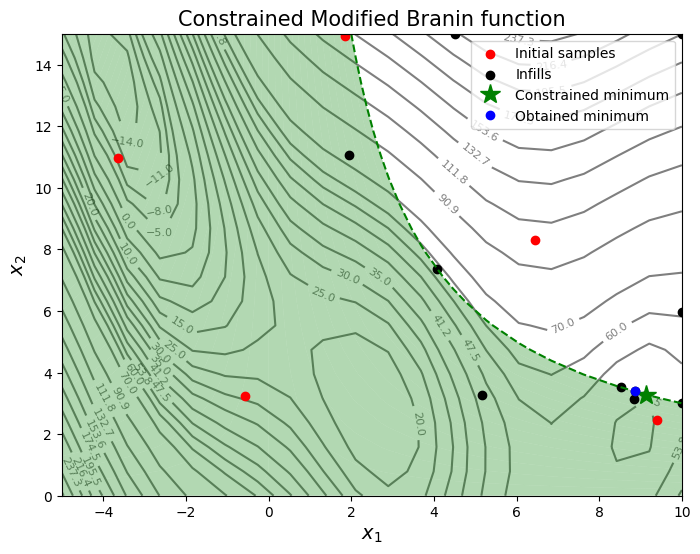

In [4]:
# Bounds
lb_plot = np.array([-5, 10])
ub_plot = np.array([0, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array([lb_plot, ub_plot]))
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)
gplot = constraint(xplot)

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)
G = gplot.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))

# Plot function
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)

# Plot constraint
ax.contour(X, Y, G, levels=[0], colors='g', linestyles='dashed')
ax.contourf(X, Y, G, levels=np.linspace(0,G.max()), colors="green", alpha=0.3, antialiased = True)

# Plot minimum
ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
ax.plot(9.143, 3.281, 'g*', markersize=15, label="Constrained minimum")
ax.plot(xtrain[index,0], xtrain[index,1], 'bo', label="Obtained minimum")

# Asthetics
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Constrained Modified Branin function", fontsize=15)
ax.legend()

Now, a post-optimality analysis will be performed for the constrained optimization problem. There are mainly two important questions that must be answered in a post-optimality analysis.

**Question:** How sensitive is the optimal solution $f^*$ to changes in the design variables $x^*$?

To answer this first question, the local sensitivies of the objective function with respect to both of the design variables will be calculated. These sensitivities will be the normalized partial derivatives of the objective function with respect to each of the design variables, $x_i$.

$$\nabla \bar{f} = \frac{x_i^*}{f(\textbf{x}^*)}\frac{\partial f}{\partial x_i}$$

In [25]:
def central_diff(x,h,index,func):
    """
        Function for computing multivariate central difference.
        Input:
        x - input at which derivative is desired
        index - variable for which the derivative is calculated
        h - step size
        func - python function which should return function value based on x.
    """

    delta = np.zeros(x.shape)
    delta[index] = 1
    x_plus = x + delta*h
    x_minus = x - delta*h
    slope = (func(x_plus.reshape(1,-1)) - func(x_minus.reshape(1,-1)))/2/h
    return slope

# Calculating slopes from surrogates
x1_slope_surrogate = (xstar[0]/sm_func.predict_values(xstar.reshape(1,-1))) * central_diff(xstar, h = 0.1, index = 0, func = sm_func.predict_values)
x2_slope_surrogate = (xstar[1]/sm_func.predict_values(xstar.reshape(1,-1))) * central_diff(xstar, h = 0.1, index = 1, func = sm_func.predict_values)
print("Normalized sensitivity of objective with respect to x1 from surrogate:", x1_slope_surrogate)
print("Normalized sensitivity of objective with respect to x2 from surrogate:", x2_slope_surrogate)

# Calculating slopes from true function
x1_slope = (xstar[0]/modified_branin(xstar)) * central_diff(xstar, h = 0.1, index = 0, func = modified_branin)
x2_slope = (xstar[1]/modified_branin(xstar)) * central_diff(xstar, h = 0.1, index = 1, func = modified_branin)
print("Normalized sensitivity of objective with respect to x1 from true function:", x1_slope)
print("Normalized sensitivity of objective with respect to x2 from true function:", x2_slope)

Normalized sensitivity of objective with respect to x1 from surrogate: [[-0.39224541]]
Normalized sensitivity of objective with respect to x2 from surrogate: [[0.19091895]]
Normalized sensitivity of objective with respect to x1 from true function: [-0.36428782]
Normalized sensitivity of objective with respect to x2 from true function: [0.18929802]


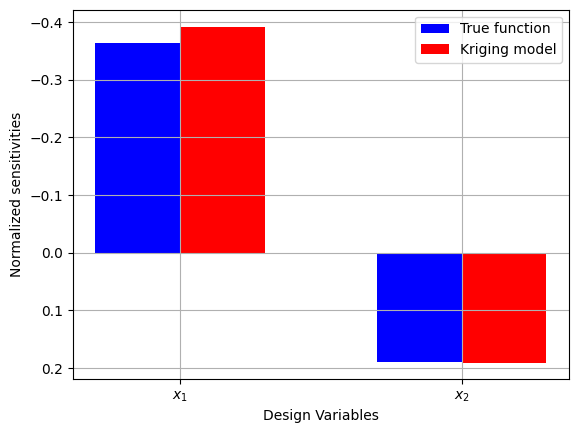

In [26]:
# Plotting objective sensitivities
vars = ['$x_1$','$x_2$']
slope_surrogate = np.array([x1_slope_surrogate.reshape(-1)[0], x2_slope_surrogate.reshape(-1)[0]])
slope_true = np.array([x1_slope[0], x2_slope[0]])
r = np.arange(len(slope_surrogate))
width = 0.3
fig, ax = plt.subplots()
ax.bar(r, slope_true, color ='blue', width = width, label = "True function")
ax.bar(r+width, slope_surrogate, color ='red', width = width, label = "Kriging model")
ax.set_xlabel("Design Variables")
ax.set_ylabel("Normalized sensitivities")
ax.set_xticks(r + width/2,vars) 
ax.invert_yaxis()
ax.legend()
ax.grid()

The plot above shows that the objective function is more sensitive to a change in $x_1$ as compared to a change in $x_2$. This is because the magnitude of the sensitivity is higher for $x_1$ as compared to $x_2$. It is also clear that the sensitivities generated using the true function and the Krigin model are comparable. This indicates that the Kriging model can provide a good prediction of the function near the optimum point.

The next question of the post-optimality analysis relates changes in the objective function to changes in the constraints of the problem. 

**Question:** How sensitive is the optimal solution $f^*$ to changes in the constraint $g(\textbf{x})$?

This question can be answered by changing the limiting value of the constraint, in this case 30, and observing the change in the optimal solution by resolving the problem using Constrained EI. Two scenarios are shown here. The first scenario reduces the limiting value of 30 by 1 unit and relaxes the constraint. The second scenario increases the limiting value of 30 by 1 unit and tightens the constraint. 

The blocks of code below solve the scenario of reducing the limiting value by 1 unit by defining a new constraint function and repeating the process of sequential sampling using constrained EI. A plot of the contours of the objective and constraint function along with other relevant quantities is also created.

In [21]:
# Definition of relaxed constraint
def relaxed_constraint(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    g = -x1*x2 + 29 # Relaxed constraint
    
    if dim == 1:
        g = g.reshape(-1)

    return g

In [22]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)
gtrain = relaxed_constraint(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-3
max_EI = [1]
ybest = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_EI[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_const = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm_func.set_training_values(xtrain, ytrain)
    sm_const.set_training_values(xtrain, gtrain)

    # Creating surrogate model
    sm_func.train()
    sm_const.train()

    # Find the best feasible sample
    ybest.append(np.min(ytrain[gtrain < 0]))
    index = np.where(ytrain == ybest[-1])[0][0]

    # Find the minimum of surrogate model
    result = minimize(ConstrainedEI(sm_func, sm_const, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[index,:].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[index,:]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    gtrain = np.append( gtrain, relaxed_constraint(result.X.reshape(1,-1)) )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest feasible point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))
print("g*: {}".format(gtrain[index]))

# Change in objective function
print("\nChange in f* with one unit reduction in constraint limit:", ybest[-1] - ystar)
print("\nPercent change in f* with one unit reduction in constraint limit:", (ybest[-1] - ystar)/ystar * 100)


Iteration 1
Maximum EI: 57.06529293770606
Best observed value: 67.06430876400562

Iteration 2
Maximum EI: 61.06979960836004
Best observed value: 67.06430876400562

Iteration 3
Maximum EI: 54.14629324558277
Best observed value: 67.06430876400562

Iteration 4
Maximum EI: 22.873059791832308
Best observed value: 67.06430876400562

Iteration 5
Maximum EI: 5.819672632080168
Best observed value: 47.89271615326155

Iteration 6
Maximum EI: 2.377408611756132
Best observed value: 47.89271615326155

Iteration 7
Maximum EI: 0.16917338184775144
Best observed value: 47.89271615326155

Iteration 8
Maximum EI: 0.0011604071104820701
Best observed value: 47.89271615326155

Iteration 9
Maximum EI: 0.22206069510476167
Best observed value: 47.89271615326155

Iteration 10
Maximum EI: 0.005632474637020338
Best observed value: 47.40077391019388

Iteration 11
Maximum EI: 1.5983879334959213e-10
Best observed value: 47.40077391019388

Best feasible point:
x*: [9.01797449 3.21595823]
f*: 47.40077391019388
g*: -0.

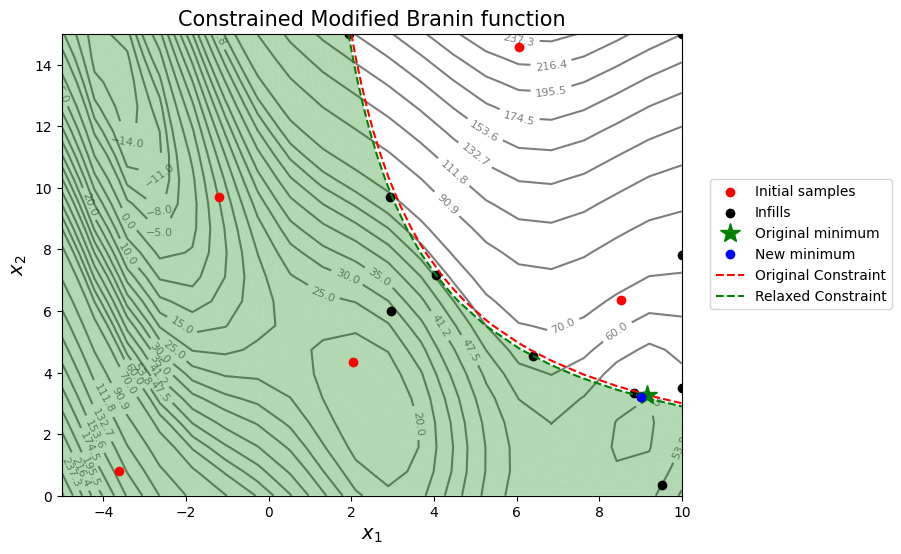

In [23]:
# Bounds
lb_plot = np.array([-5, 10])
ub_plot = np.array([0, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array([lb_plot, ub_plot]))
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)
gplot = constraint(xplot)
gplotnew = relaxed_constraint(xplot)

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)
G = gplot.reshape(reshape_size, reshape_size)
GNEW = gplotnew.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))

# Plot function
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)

# Plot constraint
cntr1 = ax.contour(X, Y, G, levels=[0], colors='r', linestyles='dashed')

# Plot relaxed constraint
cntr2 = ax.contour(X, Y, GNEW, levels=[0], colors='g', linestyles='dashed')
ax.contourf(X, Y, GNEW, levels=np.linspace(0,GNEW.max()), colors="green", alpha=0.3, antialiased = True)

# Plot minimum
sc1 = ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
sc2 = ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
sc3 = ax.plot(xstar[0], xstar[1], 'g*', markersize=15, label="Original minimum")
sc4 = ax.plot(xtrain[index,0], xtrain[index,1], 'bo', label="New minimum")

# Asthetics
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Constrained Modified Branin function", fontsize=15)
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
handles, labels = ax.get_legend_handles_labels()
handles.append(h1[0])
handles.append(h2[0])
labels.append('Original Constraint')
labels.append('Relaxed Constraint')
ax.legend(handles, labels, bbox_to_anchor = (1.35,0.7))

As seen from the results of the optimization, if the constraint limit is reduced by 1 unit the objective function reduces by a value between 0.10 and 0.25 approximately. The results will vary when the optimization is run several times. However, this is less than 1% reduction in the objective function which indicates that the objective function is not very sensitive to a reduction in the constraint limit. 

The next few code blocks will implement the scenario of increasing the contraint limit by 1 unit and resolving the optimization problem to calculate the sensitivities. The relevant contour plot is also created. 

In [24]:
# Definition of tightened constraint
def tight_constraint(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    g = -x1*x2 + 31
    
    if dim == 1:
        g = g.reshape(-1)

    return g

In [25]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)
gtrain = tight_constraint(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-3
max_EI = [1]
ybest = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_EI[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_const = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm_func.set_training_values(xtrain, ytrain)
    sm_const.set_training_values(xtrain, gtrain)

    # Creating surrogate model
    sm_func.train()
    sm_const.train()

    # Find the best feasible sample
    ybest.append(np.min(ytrain[gtrain < 0]))
    index = np.where(ytrain == ybest[-1])[0][0]

    # Find the minimum of surrogate model
    result = minimize(ConstrainedEI(sm_func, sm_const, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[index,:].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[index,:]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    gtrain = np.append( gtrain, tight_constraint(result.X.reshape(1,-1)) )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest feasible point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))
print("g*: {}".format(gtrain[index]))

# Change in objective function
print("Change in f* with one unit reduction in constraint limit:", ybest[-1] - ystar)
print("\nPercent change in f* with one unit reduction in constraint limit:", (ybest[-1] - ystar)/ystar * 100)


Iteration 1
Maximum EI: 59.226039295636134
Best observed value: 115.18587730685178

Iteration 2
Maximum EI: 69.31378265403103
Best observed value: 115.18587730685178

Iteration 3
Maximum EI: 54.14338659681651
Best observed value: 115.18587730685178

Iteration 4
Maximum EI: 66.1350254665447
Best observed value: 115.18587730685178

Iteration 5
Maximum EI: 9.416562640678348
Best observed value: 60.84497156230625

Iteration 6
Maximum EI: 8.56970107830341
Best observed value: 60.84497156230625

Iteration 7
Maximum EI: 0.05768397696109159
Best observed value: 51.95257879883069

Iteration 8
Maximum EI: 0.003079857426005663
Best observed value: 51.95257879883069

Iteration 9
Maximum EI: 2.009839924284096
Best observed value: 49.848041023126925

Iteration 10
Maximum EI: 0.09308647410149362
Best observed value: 47.795329305746456

Iteration 11
Maximum EI: 0.0012246684246897815
Best observed value: 47.795329305746456

Iteration 12
Maximum EI: 1.2568280165979639e-14
Best observed value: 47.795329

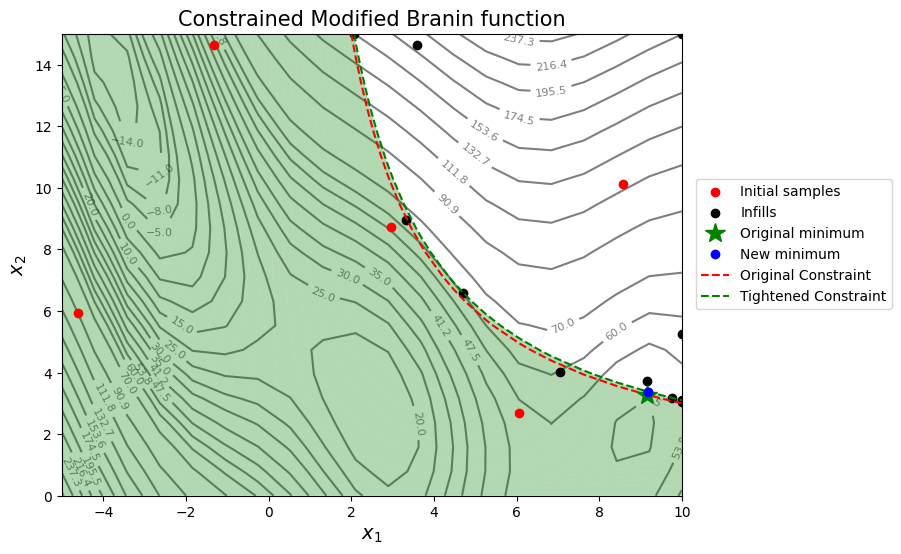

In [26]:
# Bounds
lb_plot = np.array([-5, 10])
ub_plot = np.array([0, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array([lb_plot, ub_plot]))
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)
gplot = constraint(xplot)
gplotnew = tight_constraint(xplot)

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)
G = gplot.reshape(reshape_size, reshape_size)
GNEW = gplotnew.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))

# Plot function
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)

# Plot constraint
cntr1 = ax.contour(X, Y, G, levels=[0], colors='r', linestyles='dashed')

# Plot relaxed constraint
cntr2 = ax.contour(X, Y, GNEW, levels=[0], colors='g', linestyles='dashed')
ax.contourf(X, Y, GNEW, levels=np.linspace(0,GNEW.max()), colors="green", alpha=0.3, antialiased = True)

# Plot minimum
sc1 = ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
sc2 = ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
sc3 = ax.plot(xstar[0], xstar[1], 'g*', markersize=15, label="Original minimum")
sc4 = ax.plot(xtrain[index,0], xtrain[index,1], 'bo', label="New minimum")

# Asthetics
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Constrained Modified Branin function", fontsize=15)
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
handles, labels = ax.get_legend_handles_labels()
handles.append(h1[0])
handles.append(h2[0])
labels.append('Original Constraint')
labels.append('Tightened Constraint')
ax.legend(handles, labels, bbox_to_anchor = (1.35,0.7))

In the case of increasing the constraint limit by 1 unit, there is an increase in the objective function value by approximately 0.20 to 0.30. The results will again vary when the optimization is run several times. Again, this is less than a 1% increase in the objective function which indicates that the objective function is not very sensitive to an increase in the value of the constraint limit. 